In [2]:
import os
import json
from datetime import datetime
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as plt
import dask
import graphviz
import time




## Dask

Dask is a library that helps us to coordinate the computational processes behind our code in such way that the computational power is more effectively used. This coordination can be applied on our local computer but also on external servers.

This notebook is a compromised version of this tutorial, so for more details check out this website.

https://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/dask.html



First it all starts with creating and connecting to a client which helps us to submit tasks, monitor progress and retrieve results.

In [3]:
# Let's start simple with a LocalCluster that makes use of all the cores and RAM we have on a single machine
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
# explicitly connect to the cluster we just created
client = Client(cluster)
client



/home/jlinke/miniconda3/envs/EODC/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38249 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38249/status,
Dashboard: http://127.0.0.1:38249/status,Workers: 4
Total threads: 16,Total memory: 31.24 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44161,Workers: 4
Dashboard: http://127.0.0.1:38249/status,Total threads: 16
Started: Just now,Total memory: 31.24 GiB
Comm: tcp://127.0.0.1:46443,Total threads: 4
Dashboard: http://127.0.0.1:33331/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:33053,


Workers are responsible for executing the actual computations. They fetch tasks from the scheduler, process the tasks, and then return the results. By default, Dask often configures one worker per CPU core, but this can be adjusted. Threads are smaller units of processing that run within workers, enabling parallel execution within the same worker process. Workers operate as independent processes, each with their own memory space, while threads share the same memory space within a worker, allowing for efficient data sharing and concurrent execution.

If you are working with a very large Pandas dataframe, you can consider parallizing computations by turning it into a Dask Dataframe. As an example we are going to load some volcano testing data.

In [4]:
# Load csv results from server into a Pandas DataFrame
import dask.dataframe as dd
server = 'https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?'
query = 'service=WFS&version=2.0.0&request=GetFeature&typeName=GVP-VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv'

# blocksize=None means use a single partion
df = dd.read_csv(server+query, blocksize=None)

In [5]:
# We only see the metadata, the actual data are only computed when requested.
df

,FID,Volcano_Number,Volcano_Name,Primary_Volcano_Type,Last_Eruption_Year,Country,Geological_Summary,Region,Subregion,Latitude,Longitude,Elevation,Tectonic_Setting,Geologic_Epoch,Evidence_Category,Primary_Photo_Link,Primary_Photo_Caption,Primary_Photo_Credit,Major_Rock_Type,GeoLocation
npartitions=1,,,,,,,,,,,,,,,,,,,,
,string,int64,string,string,float64,string,string,string,string,float64,float64,int64,string,string,string,string,string,string,string,string
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
# We can break up the table into 4 partions to map out to each core:
df = df.repartition(npartitions=4)
df



,FID,Volcano_Number,Volcano_Name,Primary_Volcano_Type,Last_Eruption_Year,Country,Geological_Summary,Region,Subregion,Latitude,Longitude,Elevation,Tectonic_Setting,Geologic_Epoch,Evidence_Category,Primary_Photo_Link,Primary_Photo_Caption,Primary_Photo_Credit,Major_Rock_Type,GeoLocation
npartitions=4,,,,,,,,,,,,,,,,,,,,
,string,int64,string,string,float64,string,string,string,string,float64,float64,int64,string,string,string,string,string,string,string,string
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


The Dask scheduler uses the graph layers to determine the order of task execution, ensuring that dependencies are respected. Once tasks are assigned to workers, threads within those workers execute the tasks.

In [7]:
# Let's say we want to know the minimum last eruption year for all volcanoes
last_eruption_year_min = df.Last_Eruption_Year.min()
last_eruption_year_min

<dask_expr.expr.Scalar: expr=((Repartition(frame=ReadCSV(fe764cc), new_partitions=4))['Last_Eruption_Year']).min(), dtype=float64>

Instead of getting the actual value we see dd.Scalar, which represents a recipe for the workers for actually calculating this value.


In [8]:
# To get the value call the 'compute method'
# This was slower than using pandas directly. For small data you often don't need to use parallel computing!
last_eruption_year_min.compute()

np.float64(-10450.0)

A dask array looks and feels a lot like a numpy array. However, a dask array doesn’t directly hold any data. Instead, it symbolically represents the computations needed to generate the data. Nothing is actually computed until the actual numerical values are needed. This mode of operation is called “lazy”; it allows one to build up complex, large calculations symbolically before turning them over the scheduler for execution.

If we want to create a numpy array of all ones, we do it like this:

In [9]:
import numpy as np
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [10]:
#This array contains exactly 32 MB of data
print('%.1f MB' % (ones_np.nbytes / 1e6))

32.0 MB


In [11]:
#Now let's create the same array using dask's array interface
import dask.array as da
ones = da.ones(shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

This works, but we didn’t tell dask how to split up the array, so it is not optimized for distributed computation.

A crucal difference with dask is that we must specify the chunks argument. “Chunks” describes how the array is split up over many sub-arrays. There are several ways to specify chunks but here we are going for the block shape.

In [12]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones



dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

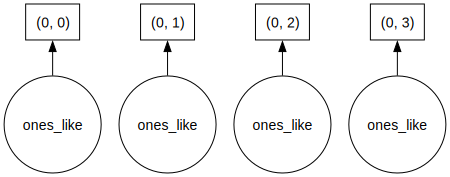

In [13]:
ones.visualize(format='svg')

We can think of the the 'ones' dask array as a matrix filled with ones. Just to take the concept a little further now we sum all the one values from the matrix to get just a single value. If we do with '.sum()' we still do not actually calculate something. It just gives us a graph that shows us how the calculation would be done working with 4 chunks and 4 workers. 

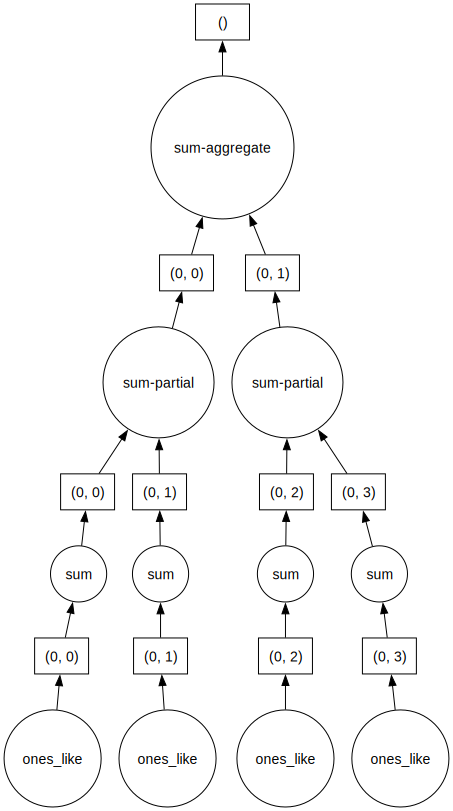

In [14]:
sum_of_ones = ones.sum()
sum_of_ones.visualize(format='svg')



If we would like to have a real computed result: 

In [15]:
result=sum_of_ones.compute()
result


np.float64(4000000.0)

## Dask delayed

With the help of dask.delayed we can decide ourselves how we want to parallize functions considering their dependencies.

In [24]:


def inc(x):
    time.sleep(0.1)
    return x + 1

def dec(x):
    time.sleep(0.1)
    return x - 1

def add(x, y):
    time.sleep(0.2)
    return x + y


In [25]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z



CPU times: user 7.61 ms, sys: 9.87 ms, total: 17.5 ms
Wall time: 400 ms


3

Here we just ran one after another function taking 400 ms to calculate. But next we are going to parallilze the functions with the help of dask.

In [18]:
inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

In [19]:
%%time

x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 197 μs, sys: 28 μs, total: 225 μs
Wall time: 210 μs


Delayed('add-354d7a36-5a76-4d9f-ab2e-fda6b6735fbf')

Now dask parallized the calculation x and y because they are independent of each other. Doing so we just created a graph but we did not actually calculate anything. Doing this took us just 168 μs. We can also visualize what we did:

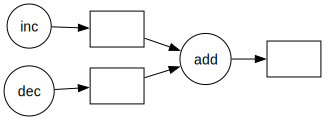

In [20]:
z.visualize(format='svg', rankdir='LR')

If we finally want to get a result:

In [21]:
%%time
z.compute()

CPU times: user 13.7 ms, sys: 791 μs, total: 14.5 ms
Wall time: 309 ms


3